In [26]:
import os, shutil
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

In [27]:
from keras.utils import image_dataset_from_directory
IMG_SIZE = 32
train_dataset = image_dataset_from_directory(train_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=512)
validation_dataset = image_dataset_from_directory(validation_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=128)
test_dataset = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=128)

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


In [28]:
from tensorflow import keras
from keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomHeight(factor=0.2),
        layers.RandomWidth(factor=0.2),
    ]
)

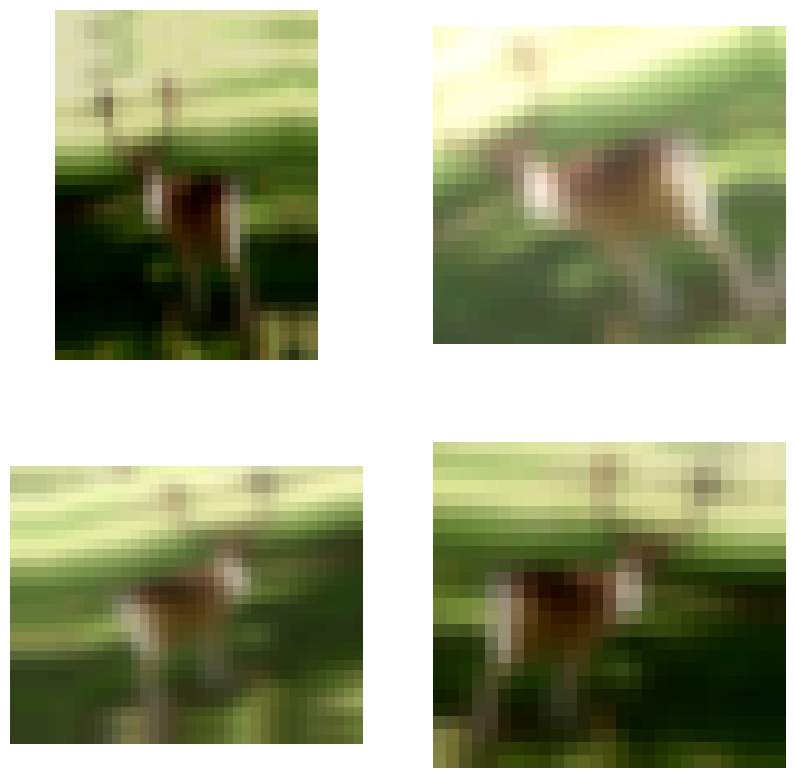

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [30]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),metrics=['acc'])

In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                      

In [31]:
history = model.fit(train_dataset,epochs=30,validation_data=validation_dataset)

Epoch 1/30
79/79 [==============================] - 10s 120ms/step - loss: 2.3587 - acc: 0.1183 - val_loss: 2.3428 - val_acc: 0.1667
Epoch 2/30
79/79 [==============================] - 9s 114ms/step - loss: 2.3121 - acc: 0.1735 - val_loss: 2.2540 - val_acc: 0.1958
Epoch 3/30
79/79 [==============================] - 10s 125ms/step - loss: 2.2234 - acc: 0.2186 - val_loss: 2.1921 - val_acc: 0.2359
Epoch 4/30
79/79 [==============================] - 10s 128ms/step - loss: 2.1499 - acc: 0.2422 - val_loss: 2.0865 - val_acc: 0.2689
Epoch 5/30
79/79 [==============================] - 11s 133ms/step - loss: 2.1006 - acc: 0.2551 - val_loss: 2.0741 - val_acc: 0.2743
Epoch 6/30
79/79 [==============================] - 10s 128ms/step - loss: 2.0533 - acc: 0.2708 - val_loss: 2.0220 - val_acc: 0.2823
Epoch 7/30
79/79 [==============================] - 10s 126ms/step - loss: 2.0127 - acc: 0.2826 - val_loss: 2.0195 - val_acc: 0.2861
Epoch 8/30
79/79 [==============================] - 10s 125ms/step - l

In [32]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)
model.save('models/projeto_3_data_augmentation.h5')

79/79 [==============================] - 1s 13ms/step - loss: 1.6226 - acc: 0.4134
val_acc: 0.41339999437332153


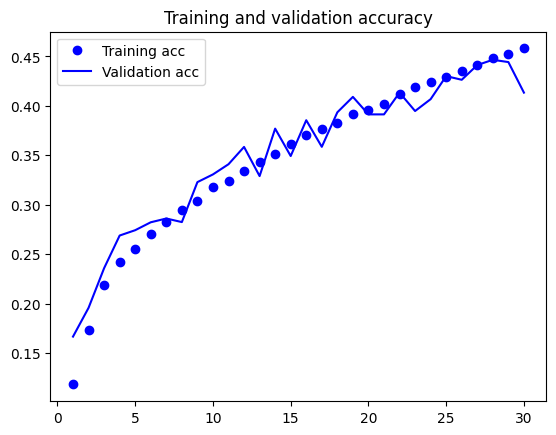

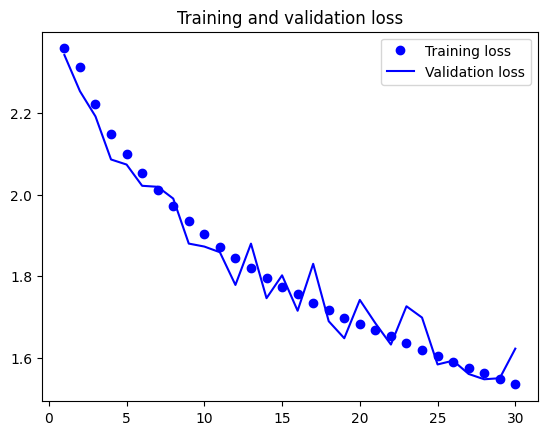

In [33]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

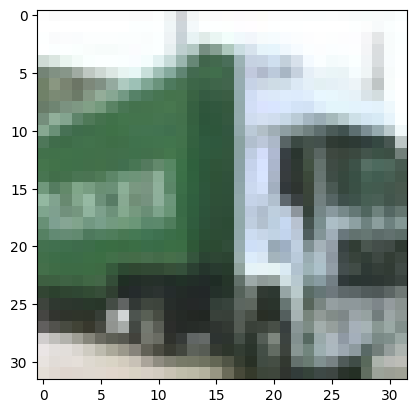

1/1 [==============================] - 0s 96ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Actual class: 009_truck ---- Predicted class: Horse
Predicted probabilities: [0.01938255 0.00707932 0.03285061 0.05606746 0.01546513 0.05269382
 0.00111625 0.6665664  0.00954228 0.13923615]


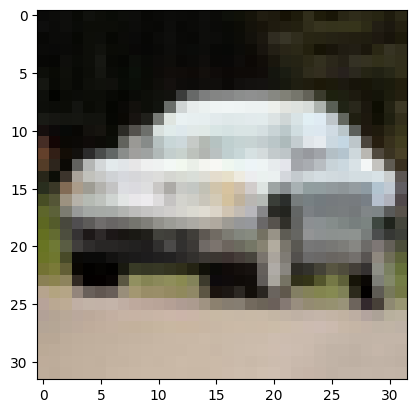

1/1 [==============================] - 0s 11ms/step
Predicted vector: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 001_automobile ---- Predicted class: Automobile
Predicted probabilities: [0.0125634  0.47669354 0.03409723 0.00373214 0.01993438 0.00229698
 0.00822554 0.05644325 0.01873931 0.36727422]


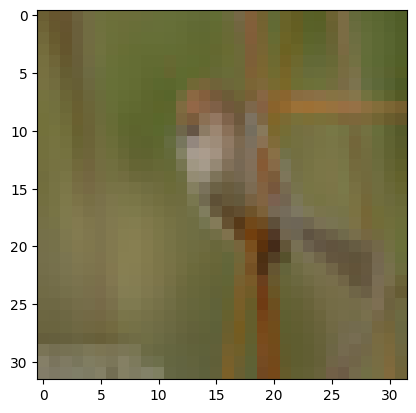

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Actual class: 002_bird ---- Predicted class: Deer
Predicted probabilities: [0.00683492 0.00516353 0.17898409 0.1643313  0.25975838 0.17010047
 0.09368114 0.11738054 0.00054373 0.00322194]


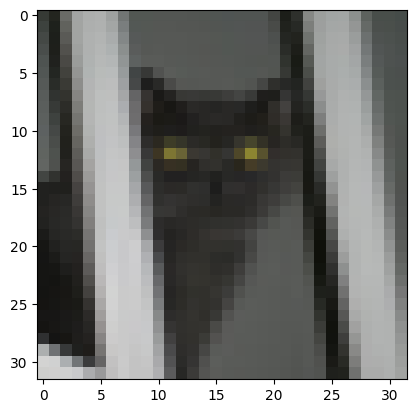

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 003_cat ---- Predicted class: Dog
Predicted probabilities: [0.00602147 0.00136191 0.13081278 0.31238046 0.04462617 0.42699862
 0.01123238 0.06430556 0.00088937 0.00137133]


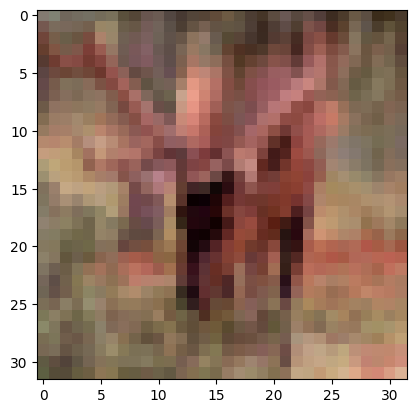

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Actual class: 004_deer ---- Predicted class: Horse
Predicted probabilities: [0.00854278 0.00275544 0.10954568 0.14688508 0.09495877 0.24124794
 0.01288038 0.37539226 0.000809   0.00698266]


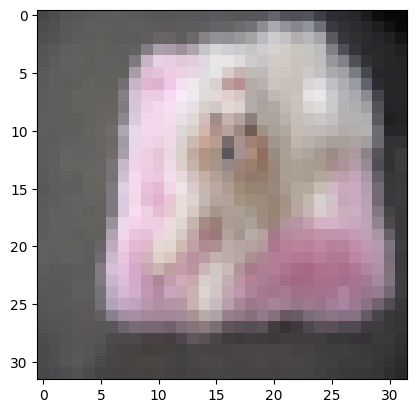

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 005_dog ---- Predicted class: Dog
Predicted probabilities: [2.1615364e-03 4.9357151e-04 4.0575612e-02 2.3713319e-01 4.5040208e-03
 6.8749124e-01 1.1050275e-03 2.1901924e-02 3.0341302e-03 1.5997222e-03]


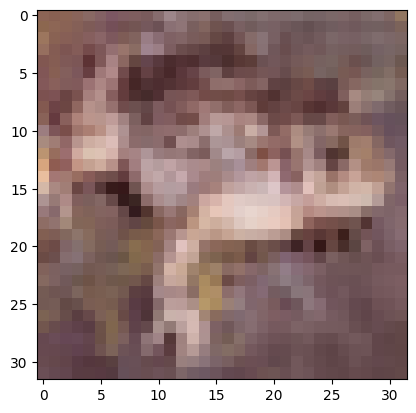

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 006_frog ---- Predicted class: Dog
Predicted probabilities: [0.00962989 0.00588184 0.13915792 0.2588189  0.13227798 0.26215538
 0.0526013  0.1265345  0.0025954  0.01034684]


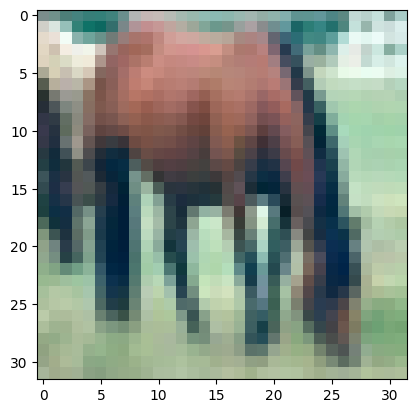

1/1 [==============================] - 0s 11ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Actual class: 007_horse ---- Predicted class: Horse
Predicted probabilities: [9.7374534e-03 1.4728714e-03 3.7735250e-02 5.6326777e-02 6.3805178e-02
 5.6208290e-02 3.3311220e-03 7.5838697e-01 4.6580783e-04 1.2530270e-02]


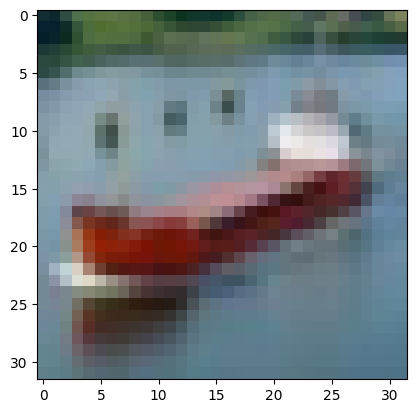

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 008_ship ---- Predicted class: Automobile
Predicted probabilities: [0.07709354 0.5214629  0.0216846  0.00376043 0.00941881 0.00174981
 0.00443655 0.00585144 0.17450407 0.1800378 ]


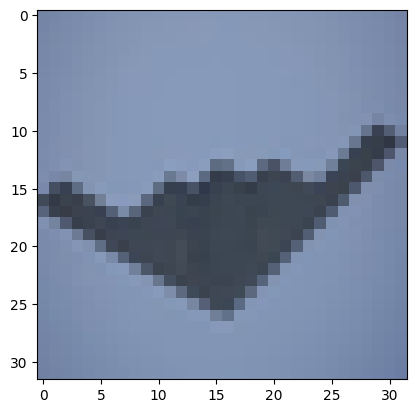

1/1 [==============================] - 0s 9ms/step
Predicted vector: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 000_airplane ---- Predicted class: Airplane
Predicted probabilities: [0.6101243  0.03332707 0.08151171 0.04746732 0.0337709  0.02393174
 0.01316043 0.01173688 0.1339783  0.01099136]


In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow import keras
import os

# Carrega o modelo salvo
model = keras.models.load_model('models/projeto_3_data_augmentation.h5')

# Função para prever a classe de uma imagem
def predict_image_class(label):
    # Diretório das imagens de treino
    img_dir = f'../train/{label}'
    
    # Lista de arquivos de imagem no diretório
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Seleciona uma imagem aleatória da lista
    random_image = random.choice(image_files)
    img_path = os.path.join(img_dir, random_image)
    
    # Carrega e exibe a imagem
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.show()
    
    # Prepara a imagem para a predição
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Realiza a predição
    predictions = model.predict(img_array)

    # Vetor de probabilidades estatísticas
    predicted_probabilities = predictions[0]
    
    # Determina a classe prevista
    predicted_class_index = np.argmax(predictions)
    
    # Vetor de predição
    predicted_vector = np.zeros_like(predictions)
    predicted_vector[0, predicted_class_index] = 1
    
    # Mapeamento de índices de classes para rótulos
    class_labels = {
        0: "Airplane",
        1: "Automobile",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck"
    }
    
    # Obtém o rótulo da classe prevista
    predicted_label = class_labels[predicted_class_index]
    
    # Exibe os resultados
    print(f"Predicted vector: {predicted_vector}")
    print(f"Actual class: {label} ---- Predicted class: {predicted_label}")
    print(f"Predicted probabilities: {predicted_probabilities}")


# Lista de rótulos para prever
labels = ['009_truck', '001_automobile', '002_bird', '003_cat', '004_deer', '005_dog', '006_frog', '007_horse', '008_ship', '000_airplane']

# Realiza predições para cada rótulo na lista
for label in labels:
    predict_image_class(label)